In [ ]:
#Hello Mam My Laptop is not taking load of extracting features from all images so I am using my another laptop

In [8]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

np.save('x_train',x_train)

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


def train_model():
    input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    autoencoder.fit(x_train_noisy, x_train,
                    epochs=2,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test),
                    callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

    autoencoder.save('autoencoder.h5')

train_model()


Epoch 1/2
244/469 [==============>...............] - ETA: 16s - loss: 0.7184

KeyboardInterrupt: 

In [86]:
#first we trained encoder and decoder together to get clear image from noisy image and then use encoder only to get 
#features of query image and images in database then find closet distance to get matching element.
import numpy as np
from keras.models import Model
from keras.datasets import mnist
import cv2
from keras.models import load_model
from sklearn.metrics import label_ranking_average_precision_score
import time
#passed original image and get retrived image or result which is matching to original image from database or folders.
print('Loading mnist dataset')
t0 = time.time()
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
t1 = time.time()
print('mnist dataset loaded in: ', t1-t0)

print('Loading model :')
t0 = time.time()
autoencoder = load_model('autoencoder.h5')
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)
t1 = time.time()
print('Model loaded in: ', t1-t0)

scores = []


def retrieve_closest_elements(test_code, test_label, learned_codes):
    distances = []
    for code in learned_codes:
        distance = np.linalg.norm(code - test_code)
        distances.append(distance)
    nb_elements = learned_codes.shape[0]
    distances = np.array(distances)
    learned_code_index = np.arange(nb_elements)
    labels = np.copy(y_train).astype('float32')
    labels[labels != test_label] = -1
    labels[labels == test_label] = 1
    labels[labels == -1] = 0
    distance_with_labels = np.stack((distances, labels, learned_code_index), axis=-1)
    sorted_distance_with_labels = distance_with_labels[distance_with_labels[:, 0].argsort()]

    sorted_distances = 28 - sorted_distance_with_labels[:, 0]
    sorted_labels = sorted_distance_with_labels[:, 1]
    sorted_indexes = sorted_distance_with_labels[:, 2]
    return sorted_distances, sorted_labels, sorted_indexes


def compute_average_precision_score(test_codes, test_labels, learned_codes, n_samples):
    out_labels = []
    out_distances = []
    retrieved_elements_indexes = []
    for i in range(len(test_codes)):
        sorted_distances, sorted_labels, sorted_indexes = retrieve_closest_elements(test_codes[i], test_labels[i], learned_codes)
        out_distances.append(sorted_distances[:n_samples])
        out_labels.append(sorted_labels[:n_samples])
        retrieved_elements_indexes.append(sorted_indexes[:n_samples])

    out_labels = np.array(out_labels)
    out_labels_file_name = 'computed_data/out_labels_{}'.format(n_samples)
    np.save(out_labels_file_name, out_labels)

    out_distances_file_name = 'computed_data/out_distances_{}'.format(n_samples)
    out_distances = np.array(out_distances)
    np.save(out_distances_file_name, out_distances)
    score = label_ranking_average_precision_score(out_labels, out_distances)
    scores.append(score)
    return score


def retrieve_closest_images(test_element, test_label, n_samples=10):
    learned_codes = encoder.predict(x_train)
    learned_codes = learned_codes.reshape(learned_codes.shape[0],
                                          learned_codes.shape[1] * learned_codes.shape[2] * learned_codes.shape[3])

    test_code = encoder.predict(np.array([test_element]))
    test_code = test_code.reshape(test_code.shape[1] * test_code.shape[2] * test_code.shape[3])

    distances = []

    for code in learned_codes:
        distance = np.linalg.norm(code - test_code)
        distances.append(distance)
    nb_elements = learned_codes.shape[0]
    distances = np.array(distances)
    learned_code_index = np.arange(nb_elements)
    labels = np.copy(y_train).astype('float32')
    labels[labels != test_label] = -1
    labels[labels == test_label] = 1
    labels[labels == -1] = 0
    distance_with_labels = np.stack((distances, labels, learned_code_index), axis=-1)
    sorted_distance_with_labels = distance_with_labels[distance_with_labels[:, 0].argsort()]

    sorted_distances = 28 - sorted_distance_with_labels[:, 0]
    sorted_labels = sorted_distance_with_labels[:, 1]
    sorted_indexes = sorted_distance_with_labels[:, 2]
    kept_indexes = sorted_indexes[:n_samples]

    score = label_ranking_average_precision_score(np.array([sorted_labels[:n_samples]]), np.array([sorted_distances[:n_samples]]))

    print("Average precision ranking score for tested element is {}".format(score))

    original_image = x_test[3]
    cv2.imshow('original_image', original_image)
    retrieved_images = x_train[int(kept_indexes[0]), :]
    for i in range(1, n_samples):
        retrieved_images = np.hstack((retrieved_images, x_train[int(kept_indexes[i]), :]))
    cv2.imshow('Results', retrieved_images)
    cv2.waitKey(0)

    cv2.imwrite('test_results/original_image.jpg', 255 * cv2.resize(original_image, (0,0), fx=3, fy=3))
    cv2.imwrite('test_results/retrieved_results.jpg', 255 * cv2.resize(retrieved_images, (0,0), fx=2, fy=2))


def test_model(n_test_samples, n_train_samples):
    learned_codes = encoder.predict(x_train)
    learned_codes = learned_codes.reshape(learned_codes.shape[0], learned_codes.shape[1] * learned_codes.shape[2] * learned_codes.shape[3])
    test_codes = encoder.predict(x_test)
    test_codes = test_codes.reshape(test_codes.shape[0], test_codes.shape[1] * test_codes.shape[2] * test_codes.shape[3])
    indexes = np.arange(len(y_test))
    np.random.shuffle(indexes)
    indexes = indexes[:n_test_samples]

    print('Start computing score for {} train samples'.format(n_train_samples))
    t1 = time.time()
    score = compute_average_precision_score(test_codes[indexes], y_test[indexes], learned_codes, n_train_samples)
    t2 = time.time()
    print('Score computed in: ', t2-t1)
    print('Model score:', score)


def plot_denoised_images():
    denoised_images = autoencoder.predict(x_test_noisy.reshape(x_test_noisy.shape[0], x_test_noisy.shape[1], x_test_noisy.shape[2], 1))
    test_img = x_test_noisy[0]
    resized_test_img = cv2.resize(test_img, (280, 280))
    cv2.imshow('input', resized_test_img)
    cv2.waitKey(0)
    output = denoised_images[0]
    resized_output = cv2.resize(output, (280, 280))
    cv2.imshow('output', resized_output)
    cv2.waitKey(0)
    cv2.imwrite('test_results/noisy_image.jpg', 255 * resized_test_img)
    cv2.imwrite('test_results/denoised_image.jpg', 255 * resized_output)


# To test the whole model
n_test_samples = 1000
n_train_samples = [10]

'''
for n_train_sample in n_train_samples:
    test_model(n_test_samples, n_train_sample)
'''
#np.save('computed_data/scores', np.array(scores))


# To retrieve closest image
retrieve_closest_images(x_test[3], y_test[3])


# To plot a denoised image
plot_denoised_images()

Loading mnist dataset
mnist dataset loaded in:  3.4992687702178955
Loading model :
Model loaded in:  0.11595726013183594
Average precision ranking score for tested element is 1.0


In [ ]:
#Suppose we have a query image with label ‘7’ and that we have four images in our database with following labels :
#‘7’, ‘7’, ‘1’, ‘0’. The first two images of the database are relevant regarding the query image,
#and the two last ones are not. The first array that we pass to the scoring function should be [1, 1, 0, 0].
#For each image on our image database we will compute a relevance score.

<class 'numpy.ndarray'>


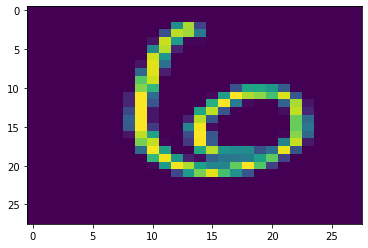

In [87]:
import matplotlib.pyplot as plt
print(type(x_test[100]))

plt.imshow(x_test[100],aspect="auto")
plt.show()

In [24]:
import glob
import cv2
import numpy as np
from numpy import asarray
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
x_train=[]
for i in glob.glob("C:\\Users\\Shivam\\Pictures\\unsupervised-image-retrieval-master\\x_train\\*.jpg"):
    image=load_img(i,target_size=(256,256))
    image=img_to_array(image, dtype='uint8')

    x_train.append(image)
x_train = asarray(x_train, dtype='float32')/255.        

In [25]:
import glob
import cv2
import numpy as np
from numpy import asarray
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
x_test=[]
for i in glob.glob("C:\\Users\\Shivam\\Pictures\\unsupervised-image-retrieval-master\\x_test\\*.jpg"):
    image=load_img(i,target_size=(256,256))
    image=img_to_array(image, dtype='uint8')

    x_test.append(image)
x_test = asarray(x_test, dtype='float32')/255.        

In [26]:
from numpy import savez_compressed
savez_compressed('own_data.npz', x_train, x_test)

In [1]:
from numpy import load
data = load('own_data.npz')
x_train, x_test = data['arr_0'], data['arr_1']
print(x_test)
print('Loaded: ',x_train.shape, x_test.shape)

[[[[0.2627451  0.2627451  0.2627451 ]
   [0.27450982 0.27450982 0.27450982]
   [0.28235295 0.28235295 0.28235295]
   ...
   [0.23921569 0.23921569 0.23921569]
   [0.23921569 0.23921569 0.23921569]
   [0.2627451  0.2627451  0.2627451 ]]

  [[0.2627451  0.2627451  0.2627451 ]
   [0.26666668 0.26666668 0.26666668]
   [0.28627452 0.28627452 0.28627452]
   ...
   [0.22352941 0.22352941 0.22352941]
   [0.20392157 0.20392157 0.20392157]
   [0.21568628 0.21568628 0.21568628]]

  [[0.26666668 0.26666668 0.26666668]
   [0.2627451  0.2627451  0.2627451 ]
   [0.29411766 0.29411766 0.29411766]
   ...
   [0.19607843 0.19607843 0.19607843]
   [0.16470589 0.16470589 0.16470589]
   [0.15294118 0.15294118 0.15294118]]

  ...

  [[0.2784314  0.2784314  0.2784314 ]
   [0.2784314  0.2784314  0.2784314 ]
   [0.27450982 0.27450982 0.27450982]
   ...
   [0.23921569 0.23921569 0.23921569]
   [0.25490198 0.25490198 0.25490198]
   [0.2509804  0.2509804  0.2509804 ]]

  [[0.24705882 0.24705882 0.24705882]
   [0.2

In [2]:
#first we trained encoder and decoder together to get clear image from noisy image and then use encoder only to get 
#features of query image and images in database then find closet distance to get matching element.
import numpy as np
from keras.models import Model
from keras.datasets import mnist
import cv2
from keras.models import load_model
from sklearn.metrics import label_ranking_average_precision_score
import time
from keras import backend as K
#passed original image and get retrived image or result which is matching to original image from database or folders.
print('Loading mnist dataset')
t0 = time.time()

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
t1 = time.time()
print('mnist dataset loaded in: ', t1-t0)

print('Loading model :')
t0 = time.time()
autoencoder = load_model('autoencoder.h5')
encoder = Model(autoencoder.layers[0].input, autoencoder.layers[8].output)
#encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)
t1 = time.time()
print('Model loaded in: ', t1-t0)

features = encoder.predict(x_train)

Loading mnist dataset
mnist dataset loaded in:  7.36215877532959
Loading model :
Model loaded in:  0.9357962608337402


In [3]:
print(features)

[[[[0.00000000e+00 7.98766017e-02 0.00000000e+00 ... 6.20910078e-02
    3.82994972e-02 7.74041861e-02]
   [0.00000000e+00 7.98766017e-02 0.00000000e+00 ... 6.20910078e-02
    3.82994972e-02 7.74041861e-02]
   [4.91438899e-03 1.53788716e-01 0.00000000e+00 ... 1.12184145e-01
    1.29823655e-01 1.20597802e-01]
   ...
   [0.00000000e+00 1.43986553e-01 0.00000000e+00 ... 1.84830770e-01
    1.76830858e-01 1.72021985e-01]
   [0.00000000e+00 2.02508271e-01 0.00000000e+00 ... 1.49018168e-01
    1.07876379e-02 1.62563831e-01]
   [0.00000000e+00 2.02508271e-01 0.00000000e+00 ... 1.49018168e-01
    1.07876379e-02 1.62563831e-01]]

  [[0.00000000e+00 7.98766017e-02 0.00000000e+00 ... 6.20910078e-02
    3.82994972e-02 7.74041861e-02]
   [0.00000000e+00 7.98766017e-02 0.00000000e+00 ... 6.20910078e-02
    3.82994972e-02 7.74041861e-02]
   [4.91438899e-03 1.53788716e-01 0.00000000e+00 ... 1.12184145e-01
    1.29823655e-01 1.20597802e-01]
   ...
   [0.00000000e+00 1.43986553e-01 0.00000000e+00 ... 1.84

In [4]:
import pickle
# construct a dictionary that maps the index of the MNIST training
# image to its corresponding latent-space representation
indexes = list(range(0, x_train.shape[0]))
data = {"indexes": indexes, "features": features}
# write the data dictionary to disk
print("[INFO] saving index...")
f = open("index.pickle", "wb")
f.write(pickle.dumps(data))
f.close()

[INFO] saving index...


In [2]:
def euclidean(a, b):
	# compute and return the euclidean distance between two vectors
	return np.linalg.norm(a - b)

In [3]:
def perform_search(queryFeatures, index, maxResults=64):
	# initialize our list of results
	results = []
	# loop over our index
	for i in range(0, len(index["features"])):
		# compute the euclidean distance between our query features
		# and the features for the current image in our index, then
		# update our results list with a 2-tuple consisting of the
		# computed distance and the index of the image
		d = euclidean(queryFeatures, index["features"][i])
		results.append((d, i))
	# sort the results and grab the top ones
	results = sorted(results)[:maxResults]
	# return the list of results
	return results

In [4]:
import time
import pickle
import numpy as np
from keras.models import Model
from keras.datasets import mnist
import cv2
from keras.models import load_model
from sklearn.metrics import label_ranking_average_precision_score
import time
from keras import backend as K
index = pickle.loads(open("index.pickle", "rb").read())
# create the encoder model which consists of *just* the encoder
t0 = time.time()
autoencoder = load_model('autoencoder.h5')
encoder = encoder = Model(autoencoder.layers[0].input, autoencoder.layers[8].output)
t1 = time.time()
print('Model loaded in: ', t1-t0)

features = encoder.predict(x_test)

Model loaded in:  1.8040266036987305


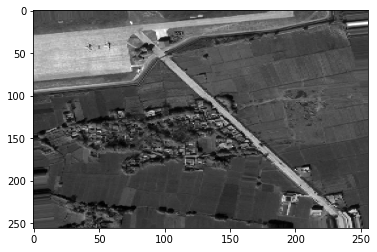

now similar image


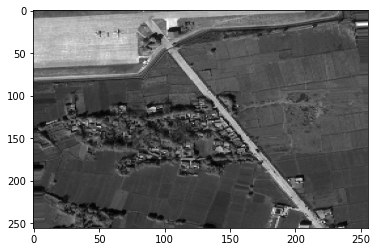

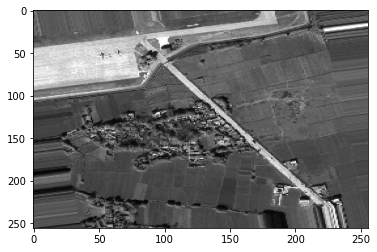

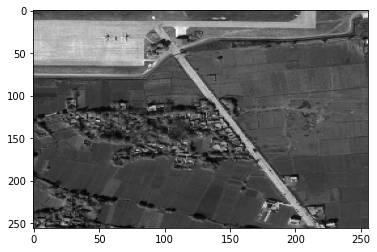

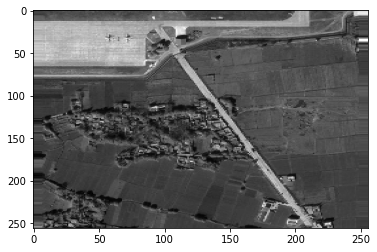

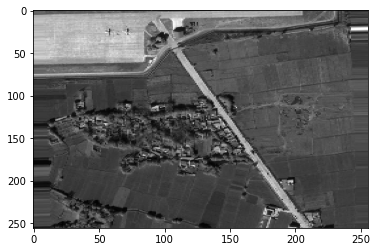

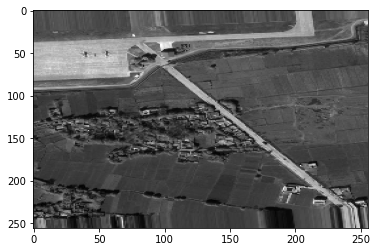

now similar image


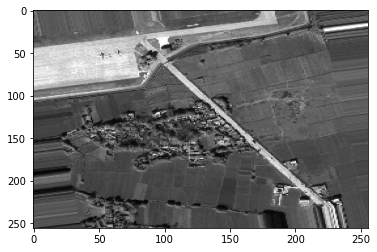

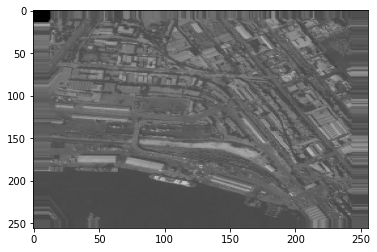

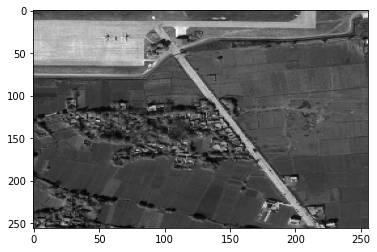

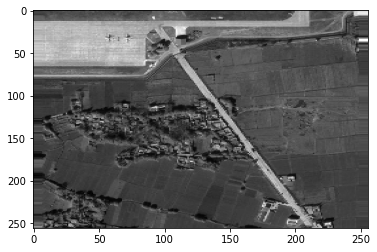

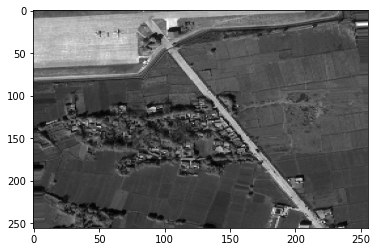

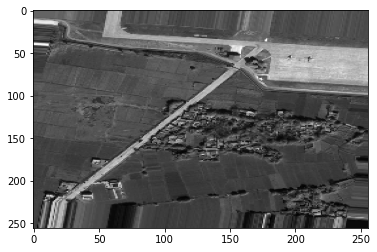

now similar image


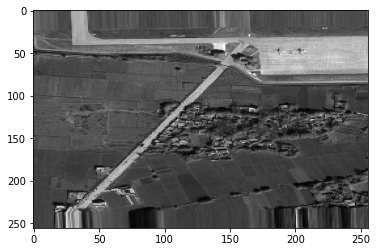

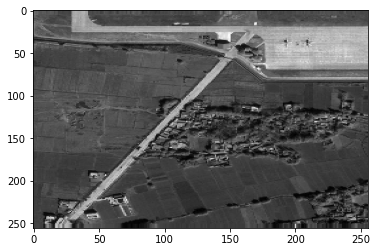

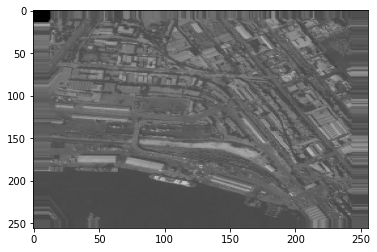

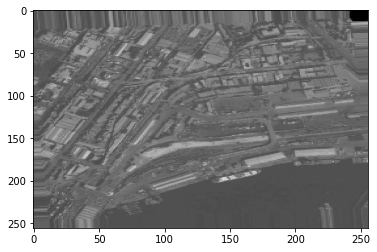

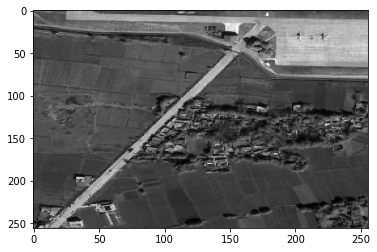

In [9]:
from imutils import build_montages
import matplotlib.pyplot as plt
# randomly sample a set of testing query image indexes
queryIdxs = 3
# queryIdxs = np.random.choice(queryIdxs, size=2,
# 	replace=False)
# loop over the testing indexes
for i in range(queryIdxs):
	# take the features for the current image, find all similar
	# images in our dataset, and then initialize our list of result
	# images
	queryFeatures = features[i]
	results = perform_search(queryFeatures, index, maxResults=5)
	images = []
	# loop over the results
	for (d, j) in results:
		# grab the result image, convert it back to the range
		# [0, 255], and then update the images list
		image = (x_train[j] * 255).astype("uint8")
		images.append(image)
	# display the query image
	query = (x_test[i] * 255).astype("uint8")
	plt.imshow(query,aspect="auto")
	plt.show()
	print("now similar image")    
	for i in range(5):
		plt.imshow(images[i],aspect="auto")
		plt.show()
    




In [25]:
import tensorflow as tf

input_img = tf.keras.layers.Input(shape=(256, 256, 3))

l1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(input_img)
l2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l1)
l3 = tf.keras.layers.MaxPool2D(padding='same')(l2)

l4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l3)
l5 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l4)
l6 = tf.keras.layers.MaxPool2D(padding='same')(l5)

l7 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l6)

l8 = tf.keras.layers.UpSampling2D()(l7)
l9 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l8)
l10 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l9)

l11 = tf.keras.layers.add([l10, l5])

l12 = tf.keras.layers.UpSampling2D()(l11)
l13 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l12)
l14 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l13)

l15 = tf.keras.layers.add([l14, l2])

decoded_image = tf.keras.layers.Conv2D(3, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l15)

auto_encoder = tf.keras.models.Model(inputs=(input_img), outputs=decoded_image)

auto_encoder.compile(optimizer='adadelta', loss='mean_squared_error')

In [27]:
import numpy as np
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.datasets import mnist
import numpy as np

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
auto_encoder.fit(x_train_noisy, x_train,
                    epochs=5,
                    batch_size=8,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test),
                    callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

auto_encoder.save('autoencoder.h5')

Epoch 1/5
65/65 [==============================] - 1113s 17s/step - loss: 0.2052 - val_loss: 0.1877
Epoch 2/5
65/65 [==============================] - 1230s 19s/step - loss: 0.1942 - val_loss: 0.1801
Epoch 3/5
65/65 [==============================] - 710s 11s/step - loss: 0.1849 - val_loss: 0.1689
Epoch 4/5
65/65 [==============================] - 499s 8s/step - loss: 0.1750 - val_loss: 0.1593
Epoch 5/5
65/65 [==============================] - 493s 8s/step - loss: 0.1663 - val_loss: 0.1511


NameError: name 'autoencoder' is not defined